In [1]:
## NOTES:
# pip install pytorch-lightning==1.5.10 
# use version 1.5.10  -> optimizer idx depreciated in newer versions

# Default Data Type: PyTorch layers and operations are optimized for torch.float32.

In [2]:
import os
import numpy as np
import cv2
# from PIL import Image
# from IPython.display import display, Image
import matplotlib.pyplot as plt
import random


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchsummary import summary

import pytorch_lightning as pl


In [3]:
torch.cuda.device_count()

1

In [4]:
torch.cuda.empty_cache()

In [5]:
BATCH_SIZE = 2
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS = int(os.cpu_count()/2)
print("AVAIL_GPUS :",AVAIL_GPUS)
print("NUM_WORKERS :",NUM_WORKERS)

AVAIL_GPUS : 1
NUM_WORKERS : 4


In [6]:
# Train_Folder ='./Dataset/Train/'
Train_Folder ='C:/Users/kevr0/OneDrive/Desktop/CPS-584/sculpture/Landscape/train1'
image_files= [f for f in os.listdir(Train_Folder) if f.endswith('.jpg')]


In [7]:
sketch_list = []
image_list = []

def generate_image(image_path):
    og_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    n_image = cv2.resize(og_image, (128, 128))
    n_image = n_image/255.0
    n_image = n_image.astype(np.float32)
    return n_image

def generate_outline(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    n_image = cv2.resize(image, (256, 256))
    blurred = cv2.GaussianBlur(n_image, (3, 3), 1)
    edges = cv2.Canny(blurred, 30, 60)
    inverted_edges = cv2.bitwise_not(edges)
    resized_image = cv2.resize(inverted_edges, (128, 128))
    gray_image_final = resized_image/255.0
    gray_image_final = np.expand_dims(gray_image_final, axis=-1)
    gray_image_final = gray_image_final.astype(np.float32)
    return gray_image_final

for image_file in image_files:
    image_path = os.path.join(Train_Folder, image_file)
    image_list.append(generate_image(image_path))
    sketch_list.append(generate_outline(image_path))
    
sketch_list[1].shape

(128, 128, 1)

In [8]:
image_list[1].shape

(128, 128, 3)

In [9]:
print(len(image_list))
print(len(sketch_list))

3390
3390


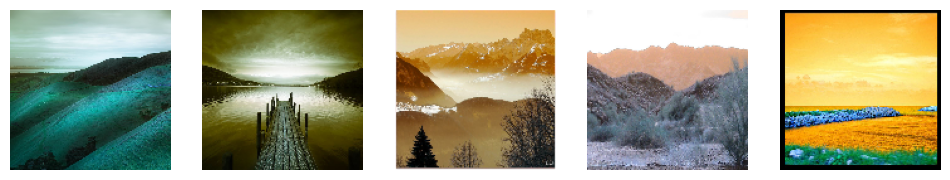

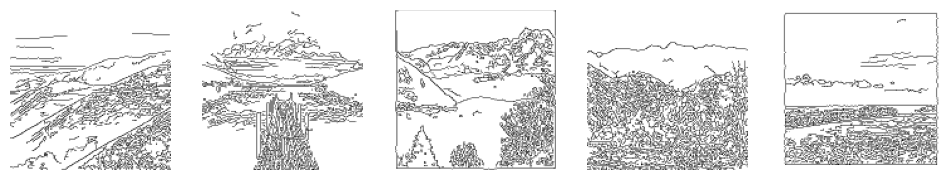

In [10]:
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image_list[i], cmap='gray')
    plt.axis('off')
plt.show()
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sketch_list[i], cmap='gray')
    plt.axis('off')
plt.show()

In [11]:

class ImageSketchDataset(Dataset):
    def __init__(self, images, sketches, transform):
        self.images = images
        self.sketches = sketches
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        sketch = self.sketches[idx]
        
        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
            sketch = self.transform(sketch)
        
        return {'image': image, 'sketch': sketch}

# Convert images and sketches to PyTorch tensors
transform = ToTensor()

# Create the dataset
# dataset = ImageSketchDataset(image_list, sketch_list, transform=transform, num_workers=NUM_WORKERS)
dataset = ImageSketchDataset(image_list, sketch_list, transform=transform)

# Create the DataLoader
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [12]:
sketch_to_gen = []
for sketch in sketch_list:
    sketch_to_gen.append(transform(sketch))
sketch_to_gen

[tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.5020, 0.5020, 0.7490,  ..., 0.7490, 0.5020, 1.0000],
          [1.0000, 1.0000, 0.7490,  ..., 0.7490, 0.5020, 0.7490],
          [1.0000, 1.0000, 1.0000,  ..., 0.5020, 0.5020, 0.5020]]]),
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]),
 tensor([[[1.0000, 1.0000, 0.7490,  ..., 0.5020, 0.7490, 1.0000],
          [0.5020, 0.5020, 0.7490,  ..., 1.0000, 0.7490, 0.2510],
          [0.5020, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.5020],
          ...,
          [1.0000, 0.5020, 1.0000,  ..., 1.0000, 1.0000, 0.5020],
          [1.0000, 0.2510, 0.5020,  .

In [13]:
img_list = []
for img in image_list:
    img_list.append(transform(img))
img_list

[tensor([[[0.5020, 0.5137, 0.5216,  ..., 0.5176, 0.5098, 0.5020],
          [0.5059, 0.5098, 0.5176,  ..., 0.5412, 0.5294, 0.5176],
          [0.5059, 0.5137, 0.5137,  ..., 0.5529, 0.5412, 0.5255],
          ...,
          [0.0314, 0.0392, 0.0275,  ..., 0.0157, 0.1490, 0.0235],
          [0.0118, 0.0196, 0.0353,  ..., 0.0000, 0.0549, 0.0039],
          [0.0314, 0.0000, 0.0118,  ..., 0.0039, 0.0157, 0.0510]],
 
         [[0.5922, 0.6039, 0.6118,  ..., 0.6039, 0.5961, 0.5882],
          [0.5961, 0.6000, 0.6078,  ..., 0.6275, 0.6157, 0.6039],
          [0.5961, 0.6039, 0.6118,  ..., 0.6471, 0.6392, 0.6235],
          ...,
          [0.2353, 0.2431, 0.2706,  ..., 0.3686, 0.5451, 0.4196],
          [0.0706, 0.1137, 0.1059,  ..., 0.2588, 0.3922, 0.3686],
          [0.0902, 0.0235, 0.0667,  ..., 0.3294, 0.3922, 0.4627]],
 
         [[0.4824, 0.4941, 0.5020,  ..., 0.5059, 0.4980, 0.4902],
          [0.4863, 0.4902, 0.4980,  ..., 0.5294, 0.5176, 0.5059],
          [0.4863, 0.4941, 0.5098,  ...,

In [14]:
for batch in dataloader:
    images = batch['image']
    sketches = batch['sketch']
    print('Batch of images shape:', images.shape)
    print('Batch of sketches shape:', sketches.shape)
    break

Batch of images shape: torch.Size([2, 3, 128, 128])
Batch of sketches shape: torch.Size([2, 1, 128, 128])


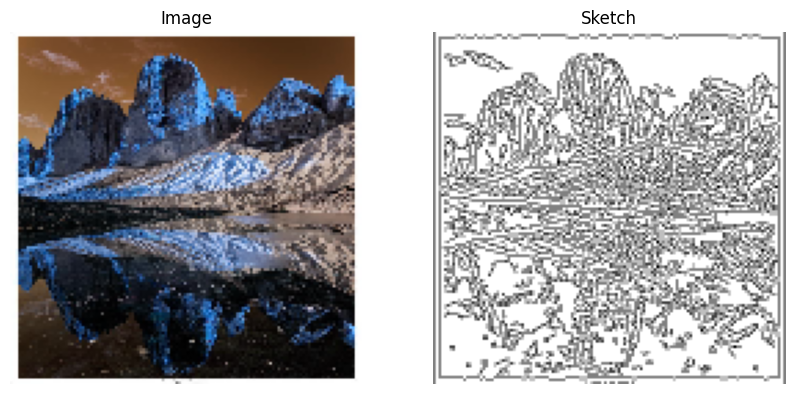

In [15]:
for batch in dataloader:
    images = batch['image']
    sketches = batch['sketch']
    break

# Select the first image and sketch from the batch
image = images[0].numpy().transpose(1, 2, 0)  # Convert from CHW to HWC format
sketch = sketches[0].numpy().squeeze()  # Remove single-channel dimension if necessary

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Display the image
ax[0].imshow(image)
ax[0].set_title('Image')
ax[0].axis('off')

# Display the sketch
ax[1].imshow(sketch, cmap='gray')
ax[1].set_title('Sketch')
ax[1].axis('off')

plt.show()

In [16]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# Conv2d
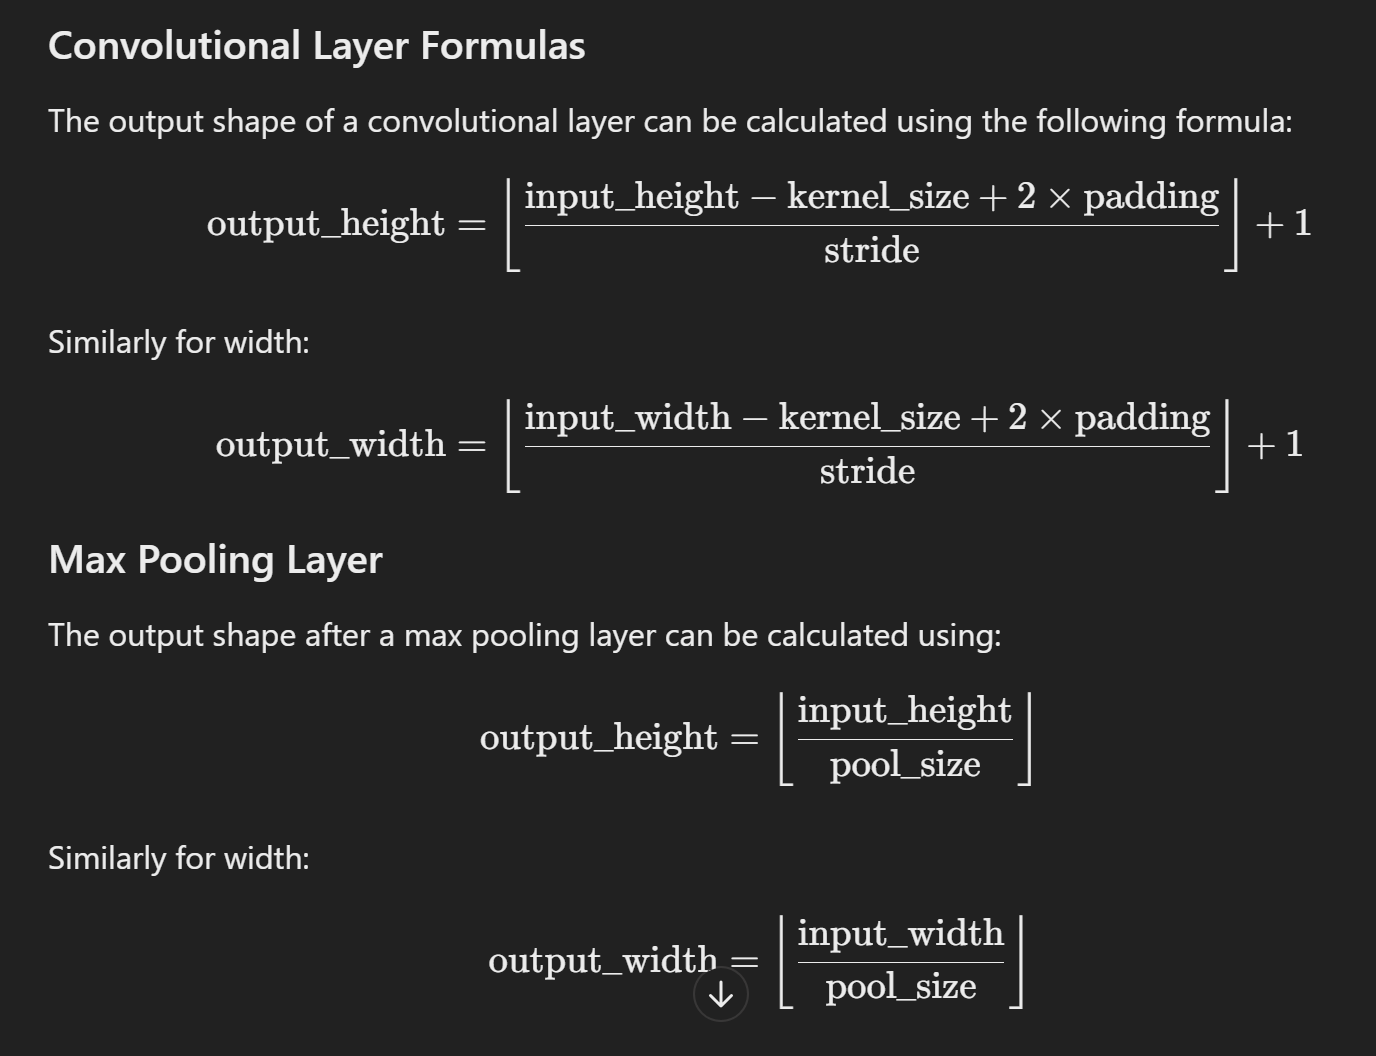

Used to flatten: value needs to be even?
x.view(-1, 64*64)


In [27]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 128, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(128, 64, kernel_size=4, stride=1, padding=2)
        self.conv2_drop = nn.Dropout2d(p = 0.2)
        self.fc1 = nn.Linear(64*32*32, 2048)
        self.fc2 = nn.Linear(2048,50)
        self.fc3 = nn.Linear(50,1)
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 64*32*32)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)

        return torch.sigmoid(x)



In [18]:
# sketch_to_gen = []
# for sketch in image_list:
#     sketch_to_gen.append(transform(sketch))
# sketch_to_gen

In [19]:
# z = random.choice(sketch_to_gen)
# z = z.unsqueeze(0)
# print(z)

In [28]:
discriminator = Discriminator().to(device)
# print(discriminator(z))
print(summary(discriminator, (3, 128, 128)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 128, 128]           9,728
            Conv2d-2           [-1, 64, 65, 65]         131,136
         Dropout2d-3           [-1, 64, 65, 65]               0
            Linear-4                 [-1, 2048]     134,219,776
            Linear-5                   [-1, 50]         102,450
            Linear-6                    [-1, 1]              51
Total params: 134,463,141
Trainable params: 134,463,141
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 20.14
Params size (MB): 512.94
Estimated Total Size (MB): 533.27
----------------------------------------------------------------
None


# ConvTranspose2d
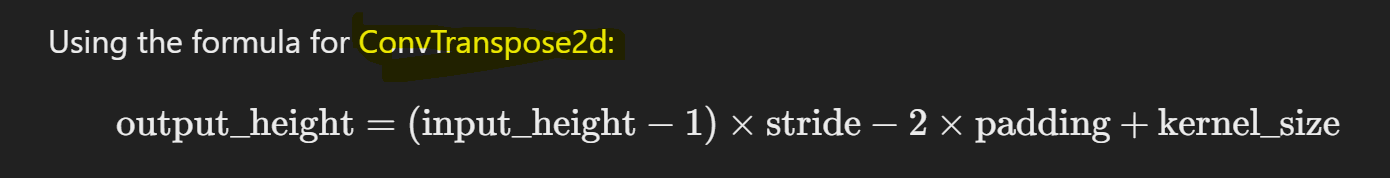
output_height=(input_height−1)×stride−2×padding+kernel_size
output_height=output_width

for :: nn.ConvTranspose2d(1, 64, kernel_size=4, stride=2, padding=1) 
will give output :: 64, output_height, output_width

if :: input = 1,128,128
then :: input_height = 128

In [21]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv2_drop = nn.Dropout2d(p = 0.2)
        self.ct1 = nn.ConvTranspose2d(1, 128, kernel_size=4, stride=2, padding=1) 
        self.ct2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.ct3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=1, padding=2)
        self.ct4 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=1, padding=1)
        
    def forward(self, x):
        # Forward pass through the network
        x = F.relu(self.ct1(x))
        x = self.conv2_drop(self.ct2(x))
        x = F.relu(F.max_pool2d(x, 2))
        x = self.conv2_drop(self.ct3(x))
        x = F.relu(F.max_pool2d(x, 2))
        x = F.relu(self.ct4(x))
        x = torch.tanh(x)
        return x    


In [22]:
# z = random.choice(sketch_to_gen)
# z = z.unsqueeze(0)
# print(z)
# z = z.to(torch.float32)
# print(z)

In [23]:
# generator = Generator().to(device)
# # print(generator(z).shape)
# print(summary(generator, (1, 128, 128)))

In [24]:
class GAN(pl.LightningModule):
    def __init__(self, latent_dim=100, lr=0.0002):
        super().__init__()
        self.save_hyperparameters()
        self.generator = Generator().to(self.device)
        self.discriminator = Discriminator().to(self.device)

    def forward(self, z):
        return self.generator(z)
    
    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)
    
    def training_step(self, batch, batch_idx, optimizer_idx):
        real_imgs = batch['image'].to(self.device)
        z = batch['sketch'].to(self.device)

        # Train Generator
        if optimizer_idx == 0:
            fake_imgs = self(z)
            # print(fake_imgs.shape)
            y_hat = self.discriminator(fake_imgs)
            # print(fake_imgs.size(0))
            y = torch.ones(y_hat.size(0),1)
            y = y.type_as(y_hat)
            g_loss = self.adversarial_loss(y_hat, y)
            log_dict = {"g_loss": g_loss}
            return {"loss":g_loss, "progress_bar":log_dict, "log":log_dict}

        # Train Discriminator
        if optimizer_idx == 1:
            # Labeling real images as real
            y_hat_real = self.discriminator(real_imgs)
            y_real = torch.ones(y_hat_real.size(0),1)
            y_real = y_real.type_as(y_hat_real)
            real_loss = self.adversarial_loss(y_hat_real, y_real)
            # Labeling fake images as fake
            y_hat_fake = self.discriminator(self(z).detach())
            y_fake = torch.zeros(y_hat_fake.size(0),1)
            y_fake = y_fake.type_as(y_hat_fake)

            fake_loss = self.adversarial_loss(y_hat_fake, y_fake)

            d_loss = (real_loss + fake_loss)/2

            log_dict = {"d_loss": d_loss}
            return {"loss":d_loss, "progress_bar":log_dict, "log":log_dict}


    def configure_optimizers(self):
        lr = self.hparams.lr
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr)
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr)
        return [opt_g, opt_d], []
    
    def plot_imgs(self, dataloader):
        for batch in dataloader:
            sketches = batch['sketch'].to(self.device)
            break
        sample_imgs = self(sketches).cpu()  # Generate images and move to CPU
        print('\nepoch ', self.current_epoch)
        fig = plt.figure()
        for i in range(sample_imgs.size(0)):
            plt.subplot(2, 3, i+1)
            plt.tight_layout()
            plt.imshow(sample_imgs.detach()[i].permute(1,2,0), interpolation='none')
            plt.title("Generated Data")
            plt.xticks([])
            plt.yticks([])
            plt.axis('off')
        plt.show()
    
    def on_epoch_end(self):
        self.plot_imgs(dataloader)

epoch  0


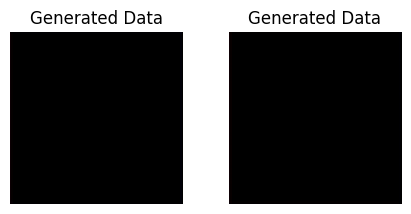

In [25]:
model = GAN()
model.plot_imgs(dataloader)

In [26]:

trainer = pl.Trainer(max_epochs=20, gpus=AVAIL_GPUS)
# trainer = pl.Trainer(max_epochs=20)

trainer.fit(model,dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 167 K 
1 | discriminator | Discriminator | 134 M 
------------------------------------------------
134 M     Trainable params
0         Non-trainable params
134 M     Total params
538.523   Total estimated model params size (MB)
c:\Users\kevr0\anaconda3\envs\datascience\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:   0%|          | 0/1695 [00:00<?, ?it/s] 

c:\Users\kevr0\anaconda3\envs\datascience\lib\site-packages\pytorch_lightning\loops\optimization\closure.py:35: LightningDeprecationWarning: One of the returned values {'progress_bar', 'log'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  rank_zero_deprecation(
c:\Users\kevr0\anaconda3\envs\datascience\lib\site-packages\pytorch_lightning\trainer\trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
